In [1]:
import numpy as np
import tensorflow as tf

In [2]:
def load_midi_data(data_dir):
    import midi.utils as utils

    midi_data = utils.midiread(data_dir, dt=0.5)

    return midi_data.piano_roll

In [3]:
midi = load_midi_data('sample1.mid')
train_x = midi[:120].astype(np.float32)
n_x = train_x.shape[1]
n_hidden = [250]
n_z = 2
n_y = n_x

frames  = train_x.shape[0]
n_batch = 6
seq_length = frames / n_batch

split_x = np.vsplit(train_x, n_batch)
n_input = 20
n_epochs = 100

In [4]:
from tensorflow.models.rnn import rnn, rnn_cell

In [5]:
from tensorflow.python.ops import variable_scope as vs
from tensorflow.python.ops import array_ops
from tensorflow.python.ops.math_ops import tanh
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import init_ops

class BasicCell(object):
    
    def __init__(self, num_units, input_size=None):
        if input_size is not None:
            logging.warn("%s: The input_size parameter is deprecated." % self)
        self._num_units = num_units
    
    def zero_state(self, dtype):
        zeros = array_ops.zeros(
            array_ops.pack([1, self._num_units]), dtype=dtype)
        zeros.set_shape([None, self._num_units])
        return zeros
    
    def __call__(self, inputs, state, scope=None):
        with vs.variable_scope(scope or type(self).__name__):
            output = tanh(self.linear([inputs, state], self._num_units, False, scope=scope))
        return output, output
    
    def linear(self, args, output_size, bias, bias_start=0.0, scope=None):
        if args is None or (isinstance(args, (list, tuple)) and not args):
            raise ValueError("`args` must be specified")
        if not isinstance(args, (list, tuple)):
            args = [args]
        # Calculate the total size of arguments on dimension 1.
        total_arg_size = 0
        shapes = [a.get_shape().as_list() for a in args]
        for shape in shapes:
            if len(shape) != 2:
                raise ValueError("Linear is expecting 2D arguments: %s" % str(shapes))
            if not shape[1]:
                raise ValueError("Linear expects shape[1] of arguments: %s" % str(shapes))
            else:
                total_arg_size += shape[1]

        # Now the computation.
        with vs.variable_scope(scope or "Linear"):
            matrix_in = vs.get_variable("MatrixIn", [shapes[0][1], shapes[1][1]])
            matrix_state = vs.get_variable("MatrixState", [shapes[1][1], output_size])
            if len(args) == 1:
                res = math_ops.matmul(args[0], matrix)
            else:
                res = math_ops.add(math_ops.matmul(args[0], matrix_in), math_ops.matmul(args[1], matrix_state))
            if not bias:
                return res
            bias_term = vs.get_variable(
            "Bias", [output_size],
            initializer=init_ops.constant_initializer(bias_start))
            return math_ops.add(res, bias_term)

In [6]:
from tensorflow.python.framework import ops
from tensorflow.python.ops.math_ops import tanh
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn_ops

def sigmoid_cross_entropy_with_logits(logits, targets, name=None):
  """Computes sigmoid cross entropy given `logits`.

  Measures the probability error in discrete classification tasks in which each
  class is independent and not mutually exclusive.  For instance, one could
  perform multilabel classification where a picture can contain both an elephant
  and a dog at the same time.

  For brevity, let `x = logits`, `z = targets`.  The logistic loss is

        z * -log(sigmoid(x)) + (1 - z) * -log(1 - sigmoid(x))
      = z * -log(1 / (1 + exp(-x))) + (1 - z) * -log(exp(-x) / (1 + exp(-x)))
      = z * log(1 + exp(-x)) + (1 - z) * (-log(exp(-x)) + log(1 + exp(-x)))
      = z * log(1 + exp(-x)) + (1 - z) * (x + log(1 + exp(-x))
      = (1 - z) * x + log(1 + exp(-x))
      = x - x * z + log(1 + exp(-x))

  To ensure stability and avoid overflow, the implementation uses

      max(x, 0) - x * z + log(1 + exp(-abs(x)))

  `logits` and `targets` must have the same type and shape.

  Args:
    logits: A `Tensor` of type `float32` or `float64`.
    targets: A `Tensor` of the same type and shape as `logits`.
    name: A name for the operation (optional).

  Returns:
    A `Tensor` of the same shape as `logits` with the componentwise
    logistic losses.

  Raises:
    ValueError: If `logits` and `targets` do not have the same shape.
  """
  with ops.op_scope([logits, targets], name, "logistic_loss") as name:
    logits = ops.convert_to_tensor(logits, name="logits")
    targets = ops.convert_to_tensor(targets, name="targets")
    try:
      targets.get_shape().merge_with(logits.get_shape())
    except ValueError:
      raise ValueError(
          "logits and targets must have the same shape (%s vs %s)"
          % (logits.get_shape(), targets.get_shape()))

    # The logistic loss formula from above is
    #   x - x * z + log(1 + exp(-x))
    # For x < 0, a more numerically stable formula is
    #   -x * z + log(1 + exp(x))
    # To avoid branching, we use the combined version
    #   max(x, 0) - x * z + log(1 + exp(-abs(x)))
    return math_ops.add(nn_ops.relu(logits) - logits * targets,
                        math_ops.log(1 + math_ops.exp(-math_ops.abs(logits))),
                        name=name)

In [7]:
class VRAE(object):
    
    def __init__(self, seq_length, n_z, n_hidden, n_input, train_x, optimizer = tf.train.AdamOptimizer()):
        tf.set_random_seed(42)
        self.learning_rate = 0.001
        self.seq_length = seq_length
        self.n_hidden = n_hidden
        self.n_input = n_input
        self.train_x = train_x
        self.n_size = 88
        network_weights = self._initialize_weights()
        self.weights = network_weights
        #self.output = tf.placeholder(tf.float32, [seq_length, self.n_size])
        self.x = tf.placeholder(tf.float32, [seq_length, self.n_size])
        self.sample_z = tf.placeholder(tf.float32, [seq_length, self.n_size])
        self.output = tf.zeros([0, self.n_size])
        
        self.basic_cell = BasicCell(n_hidden[0])
        self._initial_state = self.basic_cell.zero_state(tf.float32)
        self.state = self._initial_state
        with tf.variable_scope("RNN") as scope:
            for time_step in range(n_input):
                # x_in_t = tf.Variable(self.x[time_step].reshape((1, self.x.shape[1])))
                x_in_t = tf.reshape(tf.slice(self.x, [time_step, 0], [1, self.n_size]), (1, self.n_size))
                # x_in_t = self.x[time_step].reshape((1, self.x.shape[1]))
                if time_step > 0:
                    tf.get_variable_scope().reuse_variables()
                cell_output, self.state = self.basic_cell(x_in_t, self.state)
        
        q_mean = tf.add(tf.matmul(self.state, self.weights['W_hmu']), self.weights['b_hmu'])
        log_sigma_encoder = tf.add(tf.matmul(self.state, self.weights['W_hsigma']), self.weights['b_hsigma'])
        
        logpz = -0.5 * tf.reduce_sum(1 + log_sigma_encoder 
                                           - tf.square(q_mean) 
                                           - tf.exp(log_sigma_encoder), 1)
        
        eps = tf.random_normal(tf.shape(log_sigma_encoder), 0, 1, dtype = tf.float32)
        
        self.z = tf.add(q_mean, tf.mul(tf.exp(0.5 * log_sigma_encoder), eps))
        
        h0_dec = tf.nn.tanh(tf.add(tf.matmul(self.z, self.weights['W_zh']), self.weights['b_zh']))
        
        # out= tf.add(tf.matmul(state, self.weights['out']), self.weights['out_b'])
        # x_0 = tf.nn.sigmoid(out)
        
        #self.output = x_0
        #rec_loss = tf.nn.sigmoid_cross_entropy_with_logits(x_0, 
        #                tf.reshape(tf.slice(self.x, [0,0],[1,self.n_size]), (1, self.n_size)))
        
        #x_t = x_0
        
        self.basic_cell2 = BasicCell(self.n_hidden[0])
        state_x = tf.zeros([1, self.n_size])
        out_ = tf.zeros([0, self.n_size])
        
        with tf.variable_scope("gen") as scope:
            for i in range(0, n_input):
                if i > 0:
                    tf.get_variable_scope().reuse_variables()
                (cell_output, h0_dec) = self.basic_cell2(state_x, h0_dec)
                x_t_1 = tf.add(tf.matmul(h0_dec, self.weights['W_hx']), self.weights['b_hx'])
                state_x = tf.nn.sigmoid(x_t_1)
                out_ = tf.concat(0, [out_, state_x])
                output_t = tf.squeeze(1 / (1 + tf.exp(-(x_t_1))))
                self.output = tf.concat(0, [self.output, tf.reshape(output_t, (1, 88))])

        out_ = tf.clip_by_value(out_, 1e-6, 1 - 1e-6)
        #reconstr_loss = \
        #    -tf.reduce_sum(self.x * tf.log(1e-10 + out_)
        #                   + (1-self.x) * tf.log(1e-10 + 1 - out_),
        #                   1)
        
        logpxz = 0.5 * tf.reduce_sum(tf.pow(tf.sub(out_, self.x), 2.0))
        #reconstr_loss = -1 * tf.nn.sigmoid_cross_entropy_with_logits(out_, self.x)
            
        #logpxz = tf.reduce_mean(reconstr_loss)
        
        self.cost = tf.reduce_mean(logpxz + logpz)
        
        self.optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
            
        init = tf.initialize_all_variables()
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
        
    def _initialize_weights(self):
        all_weights = dict()
        all_weights['W_hmu'] = tf.Variable(self.xavier_init(self.n_hidden[-1], n_z))
        all_weights['b_hmu'] = tf.Variable(tf.zeros([n_z], dtype=tf.float32))
        all_weights['W_hsigma'] = tf.Variable(self.xavier_init(self.n_hidden[-1], n_z))
        all_weights['b_hsigma'] = tf.Variable(tf.zeros([n_z], dtype=tf.float32))
        all_weights['W_zh'] = tf.Variable(self.xavier_init(n_z, n_hidden[0]))
        all_weights['b_zh'] = tf.Variable(tf.zeros([self.n_hidden[0]], dtype=tf.float32))
        all_weights['W_hx'] = tf.Variable(self.xavier_init(self.n_hidden[-1], self.train_x.shape[1]))
        all_weights['b_hx'] = tf.Variable(tf.zeros([self.train_x.shape[1]], dtype=tf.float32))
        """
        all_weights['W_hmu'] = tf.Variable(tf.zeros([self.n_hidden[-1], n_z], dtype=tf.float32))
        all_weights['b_hmu'] = tf.Variable(tf.zeros([n_z], dtype=tf.float32))
        all_weights['W_hsigma'] = tf.Variable(tf.zeros([self.n_hidden[-1], n_z], dtype=tf.float32))
        all_weights['b_hsigma'] = tf.Variable(tf.zeros([n_z], dtype=tf.float32))
        all_weights['W_zh'] = tf.Variable(tf.zeros([n_z, n_hidden[0]], dtype=tf.float32))
        all_weights['b_zh'] = tf.Variable(tf.zeros([self.n_hidden[0]], dtype=tf.float32))
        all_weights['W_hx'] = tf.Variable(tf.zeros([self.n_hidden[-1], self.train_x.shape[1]], dtype=tf.float32))
        all_weights['b_hx'] = tf.Variable(tf.zeros([self.train_x.shape[1]], dtype=tf.float32))
        """
        return all_weights
    
    def xavier_init(self, fan_in, fan_out, constant = 1):
        low = -constant * np.sqrt(6.0 / (fan_in + fan_out))
        high = constant * np.sqrt(6.0 / (fan_in + fan_out))
        return tf.random_uniform((fan_in, fan_out),
                             minval = low, maxval = high,
                             dtype = tf.float32)
    
    def transform(self, X):
        self.x_sample = tf.placeholder(tf.float32, [seq_length, self.n_size])
        state = self.basic_cell.zero_state(tf.float32)
        
        with tf.variable_scope("RNN") as scope:
            for t in xrange(self.x_sample.get_shape()[0]):
                x_in_t = tf.reshape(tf.slice(self.x_sample, [t, 0], [1, self.n_size]), (1, self.n_size))
                tf.get_variable_scope().reuse_variables()
                cell_output, state = self.basic_cell(x_in_t, state)
        
        self.mu_encoder = tf.add(tf.matmul(state, self.weights['W_hmu']), self.weights['b_hmu'])
        mu_e = self.mu_encoder
        self.log_sigma_encoder = tf.add(tf.matmul(state, self.weights['W_hsigma']), self.weights['b_hsigma'])
        l_sig = self.log_sigma_encoder
        self.z_t = tf.random_normal(tf.shape(l_sig), mu_e, tf.exp(l_sig))
        
        z, mu_encoder, log_sigma_encoder = \
            self.sess.run((self.z_t, self.mu_encoder, self.log_sigma_encoder), feed_dict={self.x_sample: X})
        return z, mu_encoder, log_sigma_encoder
        
    def generate(self, Z, latent_variable, t_steps):
        
        self.z_mu = tf.placeholder(tf.float32, [1,latent_variable])
        self.x_gen = array_ops.zeros((1, self.train_x.shape[1]), dtype=tf.float32)
        h = tf.add(tf.matmul(self.z_mu, self.weights['W_zh']), self.weights['b_zh'])
        
        with tf.variable_scope("gen") as scope:
            for t in range(0, t_steps):
                tf.get_variable_scope().reuse_variables()
                x_ = tf.reshape(tf.slice(self.x_gen, [t, 0], [1, self.n_size]), (1, self.n_size))
                cell_output, h = self.basic_cell2(x_, h)
                out = tf.add(tf.matmul(h, self.weights['W_hx']), self.weights['b_hx'])
                #out= tf.add(tf.matmul(h, self.weights['out']), self.weights['out_b'])
                res = tf.squeeze(1 / (1 + tf.exp(-(out))))
                #x_0 = tf.nn.sigmoid(out)
                self.x_gen = tf.concat(0, [self.x_gen, tf.reshape(res, (1, 88))])
                
        x_gen = \
            self.sess.run((self.x_gen), feed_dict={self.z_mu: Z})
        return x_gen
    
    def get_out_weights(self):
        weight = self.sess.run((self.weights["W_hsigma"]))
        return weight
        
    def partial_fit(self, X):
        cost, opt, out, z = self.sess.run((self.cost, self.optimizer, self.output, self.z), feed_dict={self.x: X})
        return cost, out, z

In [8]:
import time
import cPickle as pickle
import copy
import midi.utils as utils

display_step = 10

model = VRAE(seq_length, n_z, n_hidden, n_input, train_x)
for epoch in xrange(1, n_epochs + 1):
    #print('epoch', epoch)
    t1 = time.time()
    total_loss = 0.0
    outputs = np.zeros(train_x.shape, dtype=np.float32)
    for i in xrange(n_batch):
        x_batch = split_x[i]
        cost, out, z = model.partial_fit(x_batch)
        outputs[i*seq_length:(i+1)*seq_length, :] = out
    if epoch % display_step == 0:
        #utils.midiwrite('VRAE_100.midi', outputs, dt=0.5)
        print "Epoch:", '%04d' % (epoch + 1), \
                "cost=", "{:.9f}".format(cost)


Epoch: 0011 cost= 50.490898132
Epoch: 0021 cost= 32.439586639
Epoch: 0031 cost= 32.940731049
Epoch: 0041 cost= 31.752468109
Epoch: 0051 cost= 32.033073425
Epoch: 0061 cost= 30.875164032
Epoch: 0071 cost= 31.011676788
Epoch: 0081 cost= 29.653312683
Epoch: 0091 cost= 28.669437408
Epoch: 0101 cost= 28.362541199


In [9]:
import collections

def convert2Midi(out):
    output = []
    for o in out:
        count_dict = collections.Counter(o)
        maxavg = max(count_dict.items(), key=lambda x:x[1])[0]
        output.append([1 if x > 0.5 else 0 for x in o])
    return np.asarray(output)

In [10]:
o_sample = load_midi_data('hotarunohikari.mid')
o_sample = o_sample[:20].astype(np.float32)

In [11]:
zo, _1, _2 = model.transform(o_sample)
z, mu_encoder, log_sigma_encoder = model.transform(split_x[0])

In [12]:
o_sample_gen = model.generate(zo, n_z, 20)
out_gen = model.generate(z, n_z, 20)

In [13]:
out_gen_conv = convert2Midi(out_gen)
o_sample_gen_conv = convert2Midi(o_sample_gen)

In [14]:
utils.midiwrite('Midi_oSample.mid', o_sample_gen_conv, dt=0.5)
utils.midiwrite('Midi_Gen.mid', out_gen_conv, dt=0.5)
utils.midiwrite('Midi_Src.mid', split_x[0], dt=0.5)

In [15]:
from pylab import *
%matplotlib inline

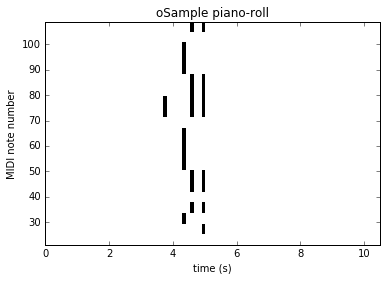

In [16]:
figure()
extent = (0, 0.5 * len(o_sample_gen_conv)) + (21, 109)
imshow(o_sample_gen_conv, origin='lower', aspect='auto',
                         interpolation='nearest', cmap=cm.gray_r,
                         extent=extent)
xlabel('time (s)')
ylabel('MIDI note number')
title('oSample piano-roll')

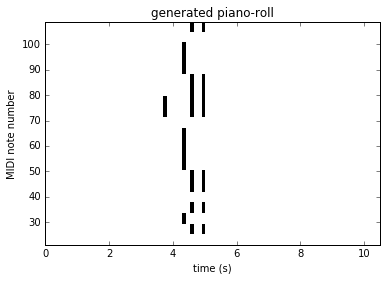

In [17]:
figure()
extent = (0, 0.5 * len(out_gen_conv)) + (21, 109)
imshow(out_gen_conv, origin='lower', aspect='auto',
                         interpolation='nearest', cmap=cm.gray_r,
                         extent=extent)
xlabel('time (s)')
ylabel('MIDI note number')
title('generated piano-roll')

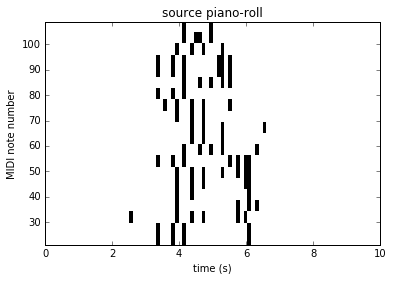

In [18]:
figure()
extent = (0, 0.5 * len(split_x[0])) + (21, 109)
imshow(split_x[0], origin='lower', aspect='auto',
                         interpolation='nearest', cmap=cm.gray_r,
                         extent=extent)
xlabel('time (s)')
ylabel('MIDI note number')
title('source piano-roll')